# Import appropriate modules

In [1]:
import numpy as np
from numpy.linalg import eigh
from numpy import load
# np.set_printoptions(threshold=np.inf, linewidth=np.inf)
# np.set_printoptions(formatter={'float': lambda x: "{0:0.3e}".format(x)})

import diatom.hamiltonian as hamiltonian
import diatom.calculate as calculate
from diatom.constants import *

import scipy.constants
from scipy.sparse import csgraph

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.gridspec import GridSpec

import mpl_interactions.ipyplot as iplt
from mpl_interactions.controller import Controls

from functools import partial

from tqdm import tqdm, trange

import itertools
import math

from tabulate import tabulate

# plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.figsize'] = (4, 3.5)
plt.rcParams['figure.dpi'] = 200
# plt.rc('text.latex', preamble=r'\usepackage[T1]{fontenc}\usepackage{cmbright}\usepackage{mathtools}')

%matplotlib widget
%config InlineBackend.figure_format = 'retina'

In [53]:
import diatom.hamiltonian as ham
N,I1,I2 = ham.generate_vecs(0,MOLECULE['I1'],MOLECULE['I2'])
H_THING = ham.scalar_nuclear(MOLECULE['C4'],I1,I2)



[[ 0  0  3  7]
 [ 0  0  3  5]
 [ 0  0  3  3]
 [ 0  0  3  1]
 [ 0  0  3 -1]
 [ 0  0  3 -3]
 [ 0  0  3 -5]
 [ 0  0  3 -7]
 [ 0  0  1  7]
 [ 0  0  1  5]
 [ 0  0  1  3]
 [ 0  0  1  1]
 [ 0  0  1 -1]
 [ 0  0  1 -3]
 [ 0  0  1 -5]
 [ 0  0  1 -7]
 [ 0  0 -1  7]
 [ 0  0 -1  5]
 [ 0  0 -1  3]
 [ 0  0 -1  1]
 [ 0  0 -1 -1]
 [ 0  0 -1 -3]
 [ 0  0 -1 -5]
 [ 0  0 -1 -7]
 [ 0  0 -3  7]
 [ 0  0 -3  5]
 [ 0  0 -3  3]
 [ 0  0 -3  1]
 [ 0  0 -3 -1]
 [ 0  0 -3 -3]
 [ 0  0 -3 -5]
 [ 0  0 -3 -7]]


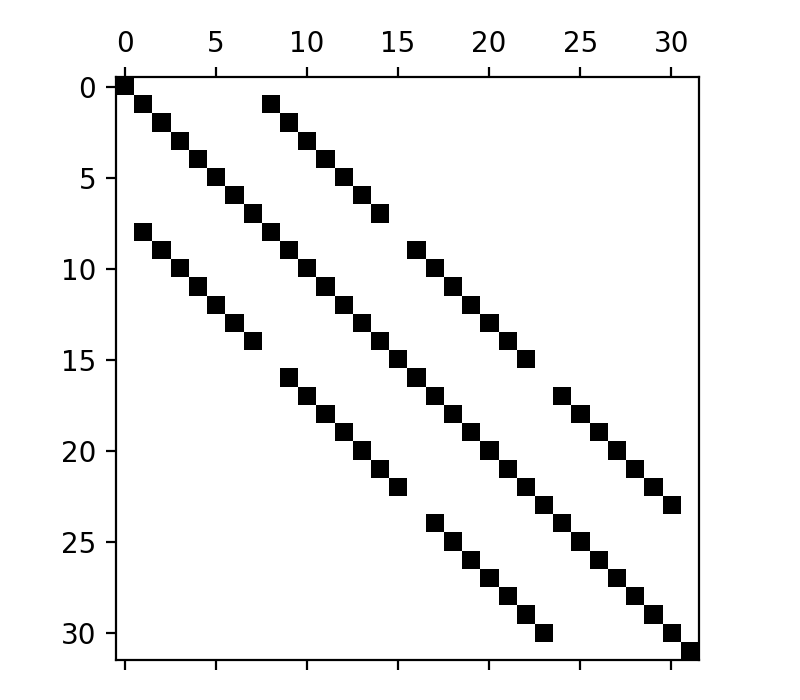

In [58]:
from matplotlib.pyplot import spy
fig,ax = plt.subplots()
ax.spy(H_THING.real)
print(UNCOUPLED_LABELS_D[0:32])

## Defining parameters

In [2]:
MOLECULE_STRING = "Rb87Cs133"
MOLECULE = Rb87Cs133
N_MAX=2

PULSE_TIME_US = 500 #μs

settings_string = f'{MOLECULE_STRING}NMax{N_MAX}PTime{PULSE_TIME_US}'
print(settings_string)

H_BAR = scipy.constants.hbar
muN = scipy.constants.physical_constants['nuclear magneton'][0]

I1 = MOLECULE["I1"]
I2 = MOLECULE["I2"]
I1_D = round(2*I1)
I2_D = round(2*I2)

D_0 = MOLECULE["d0"]

PER_MN = round((2*I1+1)*(2*I2+1))
N_STATES = PER_MN * (N_MAX+1)**2
print(f"{N_STATES} states loaded from molecule.")

GAUSS = 1e-4 # T
PULSE_TIME = PULSE_TIME_US * 1e-6 # s

B_NOISE = 35 * 1e-3 * GAUSS

# B, B_STEP_SIZE = np.linspace(B_MIN, B_MAX, B_STEPS, retstep=True) #T 

Rb87Cs133NMax2PTime500
288 states loaded from molecule.


# Load precomputed results

In [3]:
print("Loading precomputed data...")
data = np.load(f'../precomputed/{settings_string}.npz')

B=data['b']
B_MIN = B[0]
B_MAX = B[-1]
B_STEPS = len(B)

ENERGIES = data['energies']
STATES = data['states']

LABELS_D=data['labels_d']
UNCOUPLED_LABELS_D=data['uncoupled_labels_d']

MAGNETIC_MOMENTS=data['magnetic_moments'] 

COUPLINGS_ZERO=data['couplings_zero']
COUPLINGS_MINUS=data['couplings_minus']
COUPLINGS_PLUS=data['couplings_plus']
COUPLINGS = COUPLINGS_ZERO+COUPLINGS_MINUS+COUPLINGS_PLUS
POLARISED_COUPLING = [COUPLINGS_ZERO,COUPLINGS_PLUS,COUPLINGS_MINUS]

UNPOLARISED_PAIR_FIDELITIES = data['unpolarised_pair_fidelities_ut']
UNPOLARISED_PAIR_FIDELITIES = UNPOLARISED_PAIR_FIDELITIES + UNPOLARISED_PAIR_FIDELITIES.transpose(1,0,2)
POLARISED_PAIR_FIDELITIES = data['polarised_pair_fidelities_ut']
POLARISED_PAIR_FIDELITIES = POLARISED_PAIR_FIDELITIES + POLARISED_PAIR_FIDELITIES.transpose(1,0,2)
print("Precomuted data loaded.")

Loading precomputed data...
Precomuted data loaded.


# Helper Functions

In [4]:
def label_to_state_no(N,MF_D,k):
    return np.where((LABELS_D[:, 0] == N) & (LABELS_D[:, 1] == MF_D) & (LABELS_D[:, 2] == k))[0][0]

def state_no_to_uncoupled_label(state_no):
    return UNCOUPLED_LABELS_D[state_no]

In [5]:
INITIAL_STATE_LABELS_D = MOLECULE["StartStates_D"]
INITIAL_STATE_INDICES = [label_to_state_no(*label_d) for label_d in INITIAL_STATE_LABELS_D]
N_INITIAL_STATES = len(INITIAL_STATE_INDICES)

In [6]:
def label_d_to_string(label_d):
    n = label_d[0]
    mf_d = label_d[1]
    mf_frac = mf_d%2
    i = label_d[2]
    if mf_frac == 0:
        return f"({n},{mf_d//2},{i})"
    else:
        mf_whole= (mf_d - np.sign(mf_d))//2
        return f"({n},{mf_whole}.5,{i})"

def label_d_to_latex_string(label_d):
    n = label_d[0]
    mf_d = label_d[1]
    mf_frac = mf_d%2
    i = label_d[2]
    if mf_frac == 0:
        return r'|{},{}\rangle_{{{}}}'.format(n,mf_d//2,i)
    else:
        mf_whole= (mf_d - np.sign(mf_d))//2
        return r'|{},{}.5\rangle_{{{}}}'.format(n,mf_whole,i)

In [7]:
def label_degeneracy(N,MF_D):
    # Want number of ways of having
    # MF = MN + (M_I1 + M_I2) # NP-Hard Problem SSP (Subset Sum)
    d=0
    for MN in range(-N,N+1):
        for M_I1_D in range(-I1_D,I1_D+1,2):
            for M_I2_D in range(-I2_D,I2_D+1,2):
                if 2*MN+M_I1_D+M_I2_D == MF_D:
                    d+=1
    return d

In [8]:
def reachable_above_from(N,MF_D):
    sigma_plus_reachable = [(N+1,MF_D-2,i) for i in range(label_degeneracy(N+1,MF_D-2))]
    pi_reachable = [(N+1,MF_D,i) for i in range(label_degeneracy(N+1,MF_D))]
    sigma_minus_reachable = [(N+1,MF_D+2,i) for i in range(label_degeneracy(N+1,MF_D+2))]
    return (sigma_plus_reachable + pi_reachable + sigma_minus_reachable)

def twice_average_fidelity(k,g):
    return ((1 + g**2)**2 + 8*k**2*(-1 + 2*g**2) + 16*k**4)/((1 + g**2)**3 + (-8 + 20*g**2 + g**4)*k**2 + 16*k**4)

def maximum_fidelity(k,g):
    phi = np.arccos((k*(18-9*g**2-8*k**2))/(3+3*g**2+4*k**2)**(3/2))/3
    denominator = 54*((1+g**2)**3+(-8+20*g**2+g**4)*k**2+16*k**4)
    numerator = (
                 36*(g**4+(1-4*k**2)**2+2*g**2*(1+8*k**2))
               + 32*k    *(3+3*g**2+4*k**2)**(3/2) *np.cos(phi)
               - 64*k**2 *(3+3*g**2+4*k**2)        *np.cos(2*phi) 
               -  4      *(3+3*g**2+4*k**2)**2     *np.cos(4*phi)
                )
    return numerator/denominator

def fidelity(ts,d=8):
    return -np.log10(1-ts+10**(-d))

In [9]:
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

def field_to_bi(gauss):
    return find_nearest(B,gauss*GAUSS)

In [10]:
def fid_to_string(fid):
    return f"{fid:.4f}({fidelity(fid,d=9):.1f})"

# Zeeman Plot

plotting zeeman diagram...


/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/text.py:833: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/text.py:693: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/text.py:833: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/text.py:693: ComplexWarning: Casting complex val

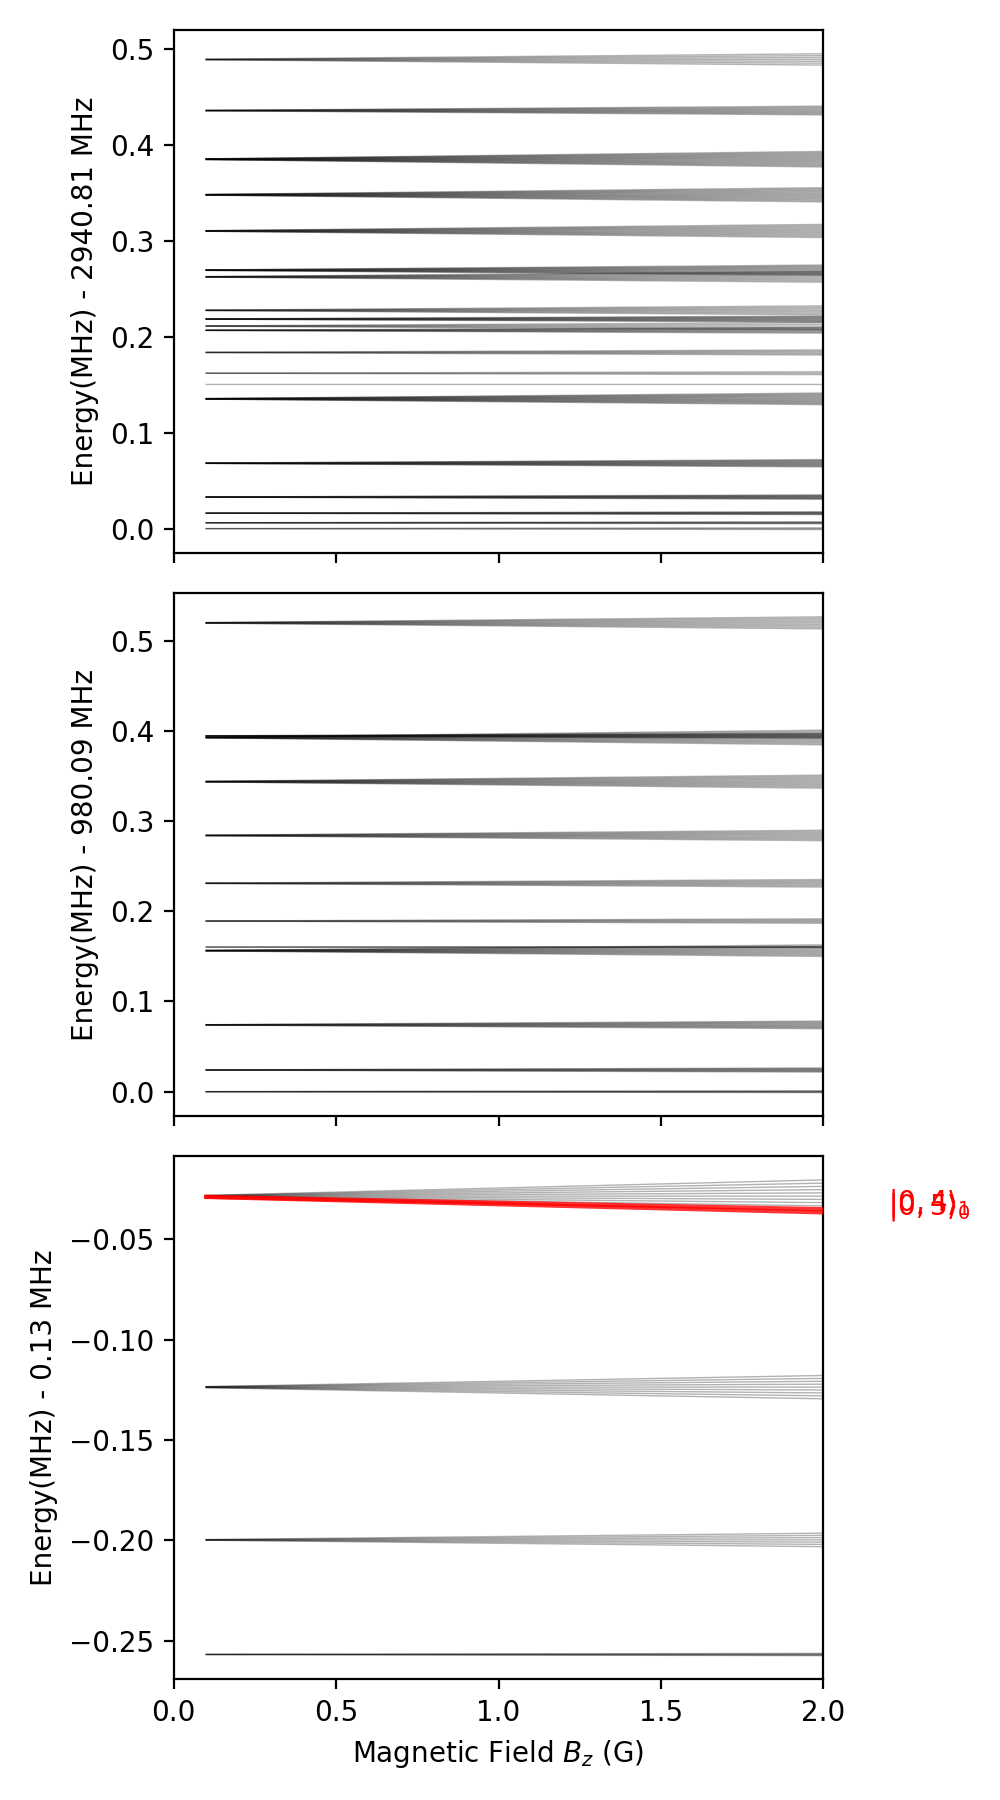

In [11]:
print("plotting zeeman diagram...")
fig, axs = plt.subplots(3,1,figsize=(5,9),sharex = True)

axs[0].set_xlim(0,0.0002/GAUSS)
axs[-1].set_xlabel('Magnetic Field $B_z$ (G)')

N=N_MAX
for ax in axs:
    base_energy = np.abs(ENERGIES[0,PER_MN*(N)**2]/(scipy.constants.h*1e6))
    ax.set_ylabel(f'Energy(MHz) - {base_energy:.2f} MHz')
    for si in range(PER_MN*(N)**2,PER_MN*(N+1)**2):
        if si in INITIAL_STATE_INDICES:
            ax.plot(B[0:20]/GAUSS,ENERGIES[0:20,si]/(scipy.constants.h*1e6)-base_energy,c='red',lw=1.5, alpha=0.8,zorder=10)
            ax.text(B[21]/GAUSS,ENERGIES[21,si]/(scipy.constants.h*1e6)-base_energy,f"${label_d_to_latex_string(LABELS_D[si])}$",c='red')
        else:
            ax.plot(B[0:20]/GAUSS,ENERGIES[0:20,si]/(scipy.constants.h*1e6)-base_energy,c='black',lw=0.5, alpha=0.3,zorder=1)
    N-=1

fig.savefig(f'../images/many-molecules/{MOLECULE_STRING}-zeeman.pdf')

In [12]:
# ui = np.where((UNCOUPLED_LABELS_D[:, 0] == 0) & (UNCOUPLED_LABELS_D[:, 1] == 0) & (UNCOUPLED_LABELS_D[:, 2] == 3)& (UNCOUPLED_LABELS_D[:, 2] == 7))[0][0]

# print(list(enumerate(UNCOUPLED_LABELS_D)))
STATES[:,96,label_to_state_no(1,8,0)]



array([-0.37697128+0.j, -0.3770914 +0.j,  0.3772114 +0.j, ...,
       -0.99547366+0.j,  0.99557107+0.j,  0.99566534+0.j])

# Magnetic moments plot

plotting magnetic moments...


/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


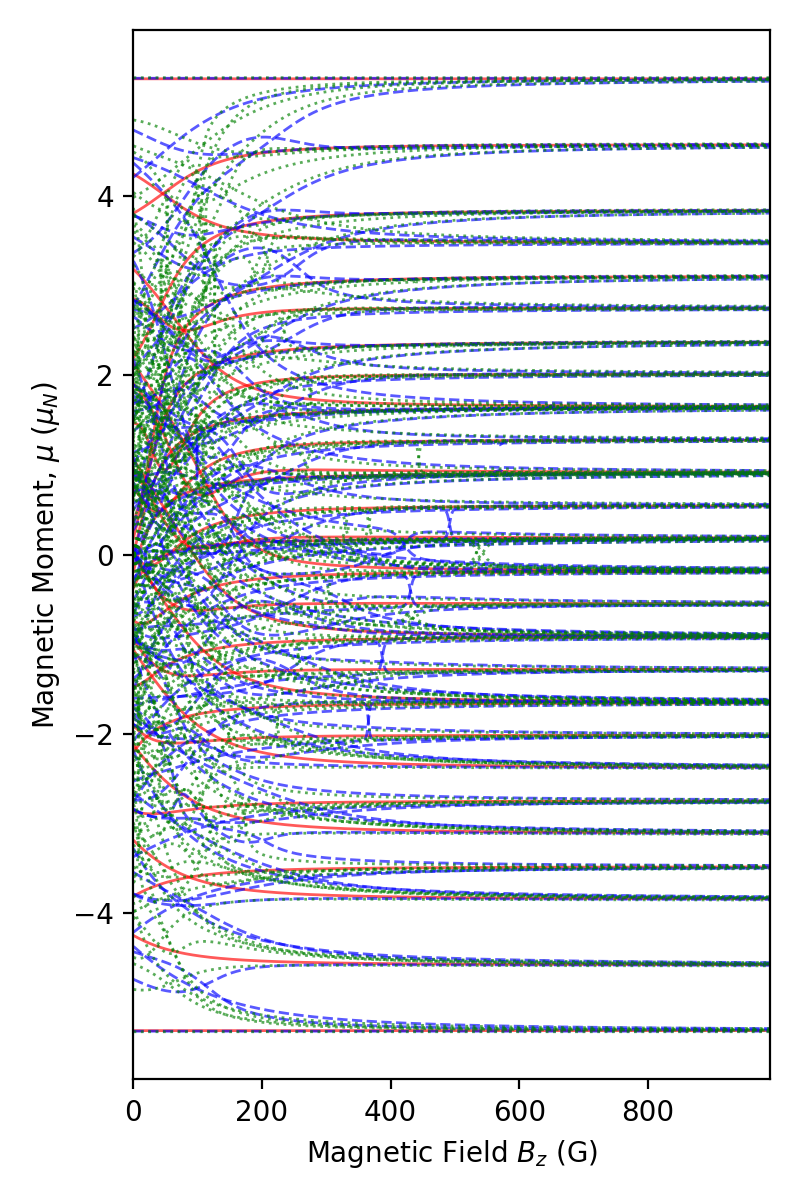

In [13]:
print("plotting magnetic moments...")
fig, ax = plt.subplots(figsize=(4,6))

ax.set_xlim(0,B_MAX/GAUSS)
ax.set_xlabel('Magnetic Field $B_z$ (G)')
ax.set_ylabel('Magnetic Moment, $\mu$ $(\mu_N)$')

states_to_plot = []
for N in range(0,3):
    Fd = 2*N + I1_D + I2_D
    for MF_D in range(-Fd,Fd+1,2):
        for di in range(label_degeneracy(N,MF_D)):
            states_to_plot.append((N,MF_D,di))

for state_label in states_to_plot:
    lw=1
    col = 'red'
    ls = 'solid'
    if state_label[0] == 1:
        ls = 'dashed'
        col='blue'
        lw=1
    if state_label[0] == 2:
        ls = 'dotted'
        col='green'
        lw=1
    
    index = label_to_state_no(*state_label)
    ax.plot(B/GAUSS, MAGNETIC_MOMENTS[:,index]/muN,linestyle=ls, color=col, alpha=0.65,linewidth=lw);

fig.savefig(f'../images/many-molecules/{MOLECULE_STRING}-magnetic-dipole-moments.pdf')

# Find best state Pi-pulse paths

In [14]:
cumulative_unpol_fidelity_from_initials = np.zeros((B_STEPS,N_INITIAL_STATES,N_STATES))
predecessor_unpol_fidelity_from_initials = np.zeros((B_STEPS,N_INITIAL_STATES,N_STATES),dtype=int)

cumulative_pol_fidelity_from_initials = np.zeros((B_STEPS,N_INITIAL_STATES,N_STATES))
predecessor_pol_fidelity_from_initials = np.zeros((B_STEPS,N_INITIAL_STATES,N_STATES),dtype=int)

for bi in range(B_STEPS):
    considered_matrix = UNPOLARISED_PAIR_FIDELITIES[:,:,bi]
    sparse_graph = csgraph.csgraph_from_dense(-np.log(considered_matrix), null_value=np.inf) # Expecting div 0 warning, this is fine
    (distances_from_initials),(predecessors_from_initials) = csgraph.shortest_path(sparse_graph,return_predecessors=True,directed=False,indices=INITIAL_STATE_INDICES)
    cumulative_unpol_fidelity_from_initials[bi]=distances_from_initials
    predecessor_unpol_fidelity_from_initials[bi]=predecessors_from_initials
    
    considered_matrix = POLARISED_PAIR_FIDELITIES[:,:,bi]
    sparse_graph = csgraph.csgraph_from_dense(-np.log(considered_matrix), null_value=np.inf) # Expecting div 0 warning, this is fine
    (distances_from_initials),(predecessors_from_initials) = csgraph.shortest_path(sparse_graph,return_predecessors=True,directed=False,indices=INITIAL_STATE_INDICES)
    cumulative_pol_fidelity_from_initials[bi]=distances_from_initials
    predecessor_pol_fidelity_from_initials[bi]=predecessors_from_initials

/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_82938/1300415643.py:9: RuntimeWarning: divide by zero encountered in log
  sparse_graph = csgraph.csgraph_from_dense(-np.log(considered_matrix), null_value=np.inf) # Expecting div 0 warning, this is fine
/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_82938/1300415643.py:15: RuntimeWarning: divide by zero encountered in log
  sparse_graph = csgraph.csgraph_from_dense(-np.log(considered_matrix), null_value=np.inf) # Expecting div 0 warning, this is fine


In [15]:
CUTOFF_DISTANCE = 0.9
CUTOFF_BI = field_to_bi(181.5)
from pyvis.network import Network
net = Network(height="1000px",width="75%",directed=False,notebook=True,cdn_resources='in_line',neighborhood_highlight=False,layout=None,filter_menu=False)
# net.repulsion()

edges = set()

cm = matplotlib.cm.get_cmap('Spectral')
colours = cm(np.linspace(0,1,N_INITIAL_STATES))
colours_hex = [matplotlib.colors.to_hex(c, keep_alpha=False) for c in colours]


for si in range(N_STATES):
    ssi = np.argmax(np.exp(-cumulative_unpol_fidelity_from_initials[CUTOFF_BI,:,si]))
    fid = np.exp(-cumulative_unpol_fidelity_from_initials[CUTOFF_BI,ssi,si])
    if fid > CUTOFF_DISTANCE: # Use me
        # Build tree
        current_back = si
        current_back_label = LABELS_D[si]
        start_index = INITIAL_STATE_INDICES[ssi]
        start_label = LABELS_D[start_index]
        predecessor_list = predecessor_unpol_fidelity_from_initials[CUTOFF_BI, ssi,:]
        
        # path = [current_back]
        # states.add(current_back)

        this_y=((fid-CUTOFF_DISTANCE)/(1-CUTOFF_DISTANCE))
        this_x=float(
            (
                current_back_label[1]-start_label[1]
                + current_back_label[2]/label_degeneracy(current_back_label[0],current_back_label[1])
            )*0.05)*(1-this_y)**(0.1) + ssi
        while current_back != start_index:
            next_back = predecessor_list[current_back]
            next_back_label = LABELS_D[next_back]
            edges.add((current_back,next_back))
            current_back = next_back
            current_back_label = next_back_label
    
        state_label = LABELS_D[si]
        label_string = label_d_to_string(state_label)
        net.add_node(int(si),label=label_d_to_string(LABELS_D[si]),x=this_x*2000,y=this_y*2000, value=float(fidelity(fid,d=5)),color=colours_hex[ssi],title=f"{label_string}, cumulative fidelity={fid}",physics=False)
        
    
pcol = ['blue','red','green']
for s,t in edges:
    fid = float(UNPOLARISED_PAIR_FIDELITIES[s,t,CUTOFF_BI])
    from_i = int(t)
    to_i = int(s)
    P = round((LABELS_D[from_i][1] - LABELS_D[to_i][1])*(LABELS_D[from_i][0] - LABELS_D[to_i][0])/2)
    ecol = pcol[P]
    net.add_edge(int(t),int(s), value=fidelity(fid,d=5),arrowStrikethrough=False,color=ecol,title=f"{fid}",physics=True)
    

            

# net.prep_notebook()
# net.show_buttons(filter_=['physics'])
net.toggle_physics(False)
net.show('test.html')

# Optimise 2-level

/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.6075544233324547


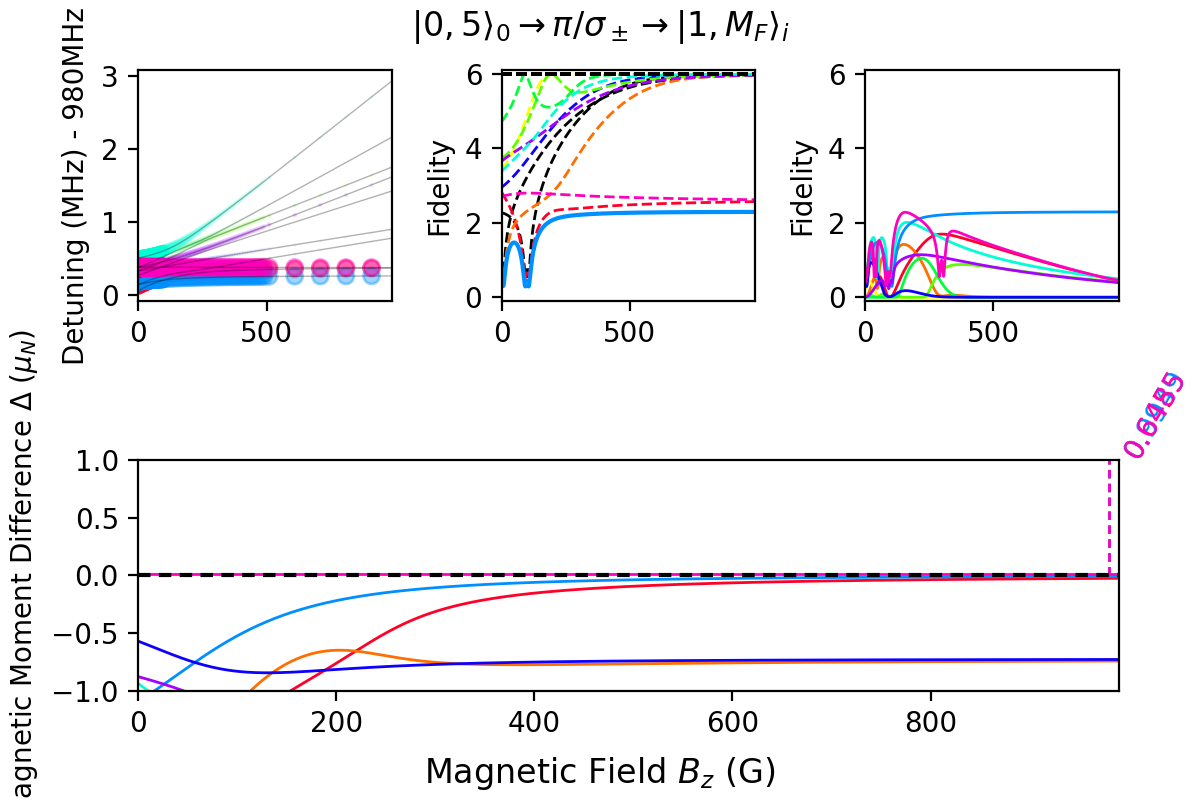

In [16]:
polarisation = None             # Polarisation: -1,0,1,None
initial_state_label_d = INITIAL_STATE_LABELS_D[0]   # Which state to go from
focus_state_label_d = (1,initial_state_label_d[1],0)     # Which state to highlight
desired_pulse_time = 100*1e-6   # What desired pulse time (s)
dynamic_range = 6               # What Dynamic range to use for Fidelity
#################################

if polarisation is None:
    coupling = COUPLINGS
    polarisation_text = '\pi/\sigma_\pm'
else:
    coupling = POLARISED_COUPLING[polarisation]
    polarisation_text = ['\pi','\sigma_+','\pi/\sigma_\pm','\sigma_-'][polarisation]

initial_state_index = label_to_state_no(*initial_state_label_d)
focus_state_index = label_to_state_no(*focus_state_label_d)

accessible_state_labels = reachable_above_from(initial_state_label_d[0],initial_state_label_d[1])
accessible_state_indices = [label_to_state_no(*label) for label in accessible_state_labels]
state_cmap = plt.cm.gist_rainbow(np.linspace(0,1,len(accessible_state_labels)))

fig = plt.figure(constrained_layout=True,figsize=(6,4))

gs = GridSpec(2, 3, figure=fig)
axl = fig.add_subplot(gs[0, 0])
axm = fig.add_subplot(gs[0, 1])
axr = fig.add_subplot(gs[0, 2])
axb = fig.add_subplot(gs[1, :])

title_string = fr"${label_d_to_latex_string(initial_state_label_d)} \rightarrow {polarisation_text} \rightarrow |1,M_F\rangle_i $"
fig.suptitle(title_string)

axl.set_xlim(0,B_MAX/GAUSS)
axm.set_xlim(0,B_MAX/GAUSS)
axr.set_xlim(0,B_MAX/GAUSS)

axm.set_ylim(-0.1,dynamic_range+0.1)
axr.set_ylim(-0.1,dynamic_range+0.1)

axl.set_ylabel("Detuning (MHz) - 980MHz")
axm.set_ylabel("Fidelity")
axr.set_ylabel("Fidelity")
fig.supxlabel('Magnetic Field $B_z$ (G)')

# Left zeeman plot
for i, state_index in enumerate(accessible_state_indices):
    this_colour = state_cmap[i]
    det = ((ENERGIES[:, state_index] - ENERGIES[:, initial_state_index]) / scipy.constants.h)
    absg = np.abs(coupling[:, initial_state_index, state_index])
    axl.scatter(B[::10]/GAUSS, det[::10]/1e6-980, color=this_colour, edgecolors=None, alpha=absg[::10]**0.5*0.5, s=absg[::10] ** 2 * 100, zorder=2)    
    axl.plot(B/GAUSS,det/1e6-980,color='k',linewidth=0.5,zorder=3,alpha=0.3)
    
# Middle single state plot
transfered = np.ones(B_STEPS)
for off_res_index in range(N_STATES):
    if off_res_index == initial_state_index or off_res_index == focus_state_index:
        continue
    this_colour=state_cmap[accessible_state_indices.index(off_res_index)] if off_res_index in accessible_state_indices else 'black'
    for (a,b) in [(initial_state_index,focus_state_index),(focus_state_index,initial_state_index)]:
        k = np.abs((ENERGIES[:, off_res_index] - ENERGIES[:, b]) * desired_pulse_time / scipy.constants.h)
        g = np.abs(coupling[:, a, off_res_index]/coupling[:, a, b])
        sub_transfered = twice_average_fidelity(k,g)
        axm.plot(B/GAUSS,fidelity(sub_transfered, dynamic_range),c=this_colour,linestyle='dashed',linewidth=1)
        transfered *= sub_transfered
axm.plot(B/GAUSS,fidelity(transfered, dynamic_range),c=state_cmap[accessible_state_indices.index(focus_state_index)])
print(transfered[30])
    

# # Right all state plots
accessible_transfered = []
for i, focus_state_index in enumerate(accessible_state_indices):
    this_colour = state_cmap[i]
    transfered = np.ones(B_STEPS)
    for off_res_index in range(N_STATES):
        if off_res_index == initial_state_index or off_res_index == focus_state_index:
            continue
        for (a,b) in [(initial_state_index,focus_state_index),(focus_state_index,initial_state_index)]:
            k = np.abs((ENERGIES[:, off_res_index] - ENERGIES[:, b]) * desired_pulse_time / scipy.constants.h)
            g = np.abs(coupling[:, a, off_res_index]/coupling[:, a, b])
            sub_transfered = twice_average_fidelity(k,g)
            transfered *= sub_transfered
    accessible_transfered.append(transfered)
    axr.plot(B/GAUSS,fidelity(transfered, dynamic_range),c=this_colour,linewidth=1)
    

axb.set_xlim(0,B_MAX/GAUSS)
axb.set_ylim(-1,1)
# axb.set_xlabel('Magnetic Field $B_z$ (G)')
axb.set_ylabel('Magnetic Moment Difference $\Delta$ $(\mu_N)$')


axb.axhline(0, dashes=(3, 2), color='k', linewidth=1.5, alpha=1, zorder=3)
for i, focus_state_index in enumerate(accessible_state_indices):
    this_colour = state_cmap[i]
    magnetic_moment_difference = (MAGNETIC_MOMENTS[:,focus_state_index]-MAGNETIC_MOMENTS[:,initial_state_index])
    axb.plot(B/GAUSS,magnetic_moment_difference/muN, alpha=1,linewidth=1,zorder=1,c=this_colour)
    abs_magnetic_moment_difference = np.abs(magnetic_moment_difference)
    min_delta = np.argmin(abs_magnetic_moment_difference)
    if abs_magnetic_moment_difference[min_delta]/muN < 0.3:
        this_transferred = accessible_transfered[i][min_delta]
        if this_transferred < 0.5:
            continue
        text_place = B[min_delta]/GAUSS
        line_place = max(min(B[min_delta]/GAUSS,B_MAX/GAUSS*0.99),B_MAX/GAUSS*0.01)
        axb.axvline(line_place,ymin=0.5,color=this_colour,linewidth=1,dashes=(3,2))
        this_transferred = accessible_transfered[i][min_delta]
        this_transferred_string = f"{this_transferred:.4f}"
        axb.text(text_place,1.02,this_transferred_string,rotation=60,c=this_colour)

# fig.savefig('../images/2-level-optimisation')

# Generic Optimisation Routine

In [17]:
a = 0.01*(muN)*B_NOISE/(scipy.constants.h)
b = 4*(np.pi**2) * 1 / (1e6)**2

In [18]:
print(a,b)

0.2667907630188613 3.947841760435743e-11


In [19]:
def maximise_fid_dev(possibilities, loop=False, required_crossing=None, max_bi=B_STEPS, allow_travel=True,
                     rate_deviation_fid=True, rate_unpol_distance_fid=True, rate_pol_distance_fid=False, rate_unpol_fid=True, rate_pol_fid=False,
                     plot=True, table_len=8, latex_table=False, x_plots=4, y_plots=1, save_name=None):
    n_comb = len(possibilities)
    n_waves = len(possibilities[0]) - 1 # NOTE: assumes paths are the same length
    n_plots = x_plots*y_plots
    consider_top=max(n_plots,table_len)
    print(n_comb, "combinations to consider")
    possibilities_indices = np.array([np.array([label_to_state_no(*label) for label in possibility]) for possibility in possibilities])

    deviation_fid = np.zeros((B_STEPS, consider_top),dtype=np.double)
    unpol_distance_fid = np.zeros((B_STEPS, consider_top),dtype=np.double)
    pol_distance_fid = np.zeros((B_STEPS, consider_top),dtype=np.double)    
    unpol_fid = np.zeros((B_STEPS, consider_top),dtype=np.double)
    pol_fid = np.zeros((B_STEPS, consider_top),dtype=np.double)
    
    rating = np.zeros((B_STEPS,consider_top),dtype=np.double)
    peak_rating = np.zeros((consider_top),dtype=np.double)
    peak_rating_index = np.zeros((consider_top),dtype=int)

    worst_rating_so_far = 0
    for i, desired_indices in tqdm(enumerate(possibilities_indices),total=n_comb):
        this_rating = np.ones((B_STEPS),dtype=np.double)
        
        # Find path to get there from initial state
        if allow_travel:
            this_unpol_distance_fid = np.exp(-np.min(cumulative_unpol_fidelity_from_initials[:,:,desired_indices],axis=(1,2)))
            if rate_unpol_distance_fid:
                this_rating *= this_unpol_distance_fid
                if np.max(this_rating) < worst_rating_so_far:
                    continue
            this_pol_distance_fid = np.exp(-np.min(cumulative_pol_fidelity_from_initials[:,:,desired_indices],axis=(1,2)))
            if rate_pol_distance_fid:
                this_rating *= this_pol_distance_fid
                if np.max(this_rating) < worst_rating_so_far:
                    continue
        else:
            intersection = np.any(np.isin(desired_indices, INITIAL_STATE_INDICES, assume_unique=True))
            if intersection:
                this_unpol_distance_fid = np.ones(B_STEPS)
                this_pol_distance_fid = np.ones(B_STEPS)
            else:
                continue
        
        # Simulate microwave transfers to find fidelity *within structure*
        this_unpol_fid = np.ones(B_STEPS,dtype=np.double)
        this_pol_fid = np.ones(B_STEPS,dtype=np.double)
        for n in range(n_waves):
            this_unpol_fid *= UNPOLARISED_PAIR_FIDELITIES[desired_indices[n],desired_indices[n+1],:]
            this_pol_fid *= POLARISED_PAIR_FIDELITIES[desired_indices[n],desired_indices[n+1],:]
        if loop:
            this_unpol_fid *= UNPOLARISED_PAIR_FIDELITIES[desired_indices[0],desired_indices[-1],:]
            this_pol_fid *= POLARISED_PAIR_FIDELITIES[desired_indices[0],desired_indices[-1],:]
        if rate_unpol_fid:
            this_rating *= this_unpol_fid
            if np.max(this_rating) < worst_rating_so_far:
                continue
        if rate_pol_fid:
            this_rating *= this_pol_fid
            if np.max(this_rating) < worst_rating_so_far:
                continue
                
        # Find best B for minimum dipole deviation
        all_moments = MAGNETIC_MOMENTS[:,desired_indices]
        this_deviation = np.abs((np.amax(all_moments,axis=1) - np.amin(all_moments,axis=1)))
        this_deviation_fid = np.exp(-(PULSE_TIME/2)*this_deviation*B_NOISE/(scipy.constants.h))
        if rate_deviation_fid:
            this_rating *= this_deviation_fid
            if required_crossing is not None:
                required_deviation = all_moments[:,required_crossing[0]]-all_moments[:,required_crossing[1]]
                sign_changes = np.where(np.diff(np.sign(required_deviation)))[0]
                mask = np.ones(max_bi, dtype=bool)
                mask[sign_changes] = False
                mask[sign_changes+1] = False
                this_rating[mask] = 0
            if np.max(this_rating) < worst_rating_so_far:
                continue
                
        this_peak_rating = np.max(this_rating)
        better_array = this_peak_rating - peak_rating
        partitioned_array = np.argpartition(better_array, -2)
        the_worst_index = partitioned_array[-1]
        the_second_worst_index = partitioned_array[-2]
        the_worst_difference = better_array[the_worst_index]
        if the_worst_difference > 0:
            peak_rating[the_worst_index] = this_peak_rating
            peak_rating_index[the_worst_index] = i
            
            unpol_distance_fid[:,the_worst_index] = this_unpol_distance_fid
            pol_distance_fid[:,the_worst_index] = this_pol_distance_fid
            deviation_fid[:,the_worst_index] = this_deviation_fid
            unpol_fid[:,the_worst_index] = this_unpol_fid
            pol_fid[:,the_worst_index] = this_pol_fid
        
            rating[:,the_worst_index] = this_rating
            worst_rating_so_far = min(this_peak_rating,peak_rating[the_second_worst_index])
        else:
            worst_rating_so_far = peak_rating[the_worst_index]

    order = (-peak_rating).argsort()
    
    # Display Results
    if plot:
        fig, axs = plt.subplots(y_plots,x_plots,figsize=(10,10),dpi=100,sharex=True,sharey=True,constrained_layout=True)
        if n_plots > 1:
            axs = axs.flatten()
        else:
            axs = [axs]
    headers = ['States', 'B(G)', 'MagDipFid', 'UnPolFid', 'PolFid', 'UnPolDistFid', 'PolDistFid', 'UnPolOverall', 'PolOverall', 'Rating', 'Path']
    data = []
    for i in range(table_len):
        besti = order[i]
        combi = peak_rating_index[besti]
        state_labels = possibilities[combi]
        state_numbers = np.array([label_to_state_no(*state_label) for state_label in state_labels])
        
        this_rating = rating[:,besti]
        peak_rating_bi = np.argmax(this_rating)
        peak_rating = this_rating[peak_rating_bi]
        peak_magnetic_field = B[peak_rating_bi]
        
        this_unpol_distance_fid = unpol_distance_fid[:,besti]
        this_pol_distance_fid = pol_distance_fid[:,besti]
        this_deviation_fid = deviation_fid[:,besti]
        this_unpol_fid = unpol_fid[:,besti]
        this_pol_fid = pol_fid[:,besti]
        
        this_unpol_overall = this_deviation_fid*this_unpol_distance_fid*this_unpol_fid
        this_pol_overall = this_deviation_fid*this_pol_distance_fid*this_pol_fid
        
        peak_pol_distance_fid = this_pol_distance_fid[peak_rating_bi]
        peak_unpol_distance_fid = this_unpol_distance_fid[peak_rating_bi]
        peak_deviation_fid = this_deviation_fid[peak_rating_bi]
        peak_unpol_fid = this_unpol_fid[peak_rating_bi]
        peak_pol_fid = this_pol_fid[peak_rating_bi]
        
        peak_unpol_overall = this_unpol_overall[peak_rating_bi]
        peak_pol_overall = this_pol_overall[peak_rating_bi]
        
        if plot and i<n_plots:
            ax = axs[i]
            ax.set_xlim(0,B_MAX/GAUSS)
            ax.set_ylim(0,5)

            # ax.plot(B/GAUSS, fidelity(this_deviation_fid,d=5), linestyle='solid', c='blue', alpha=0.4)
            
            ax.plot(B/GAUSS, fidelity(this_unpol_distance_fid,d=5), linestyle='dashed', c='red', alpha=0.8)
            ax.plot(B/GAUSS, fidelity(this_pol_distance_fid,d=5), linestyle='dashed', c='green', alpha=0.8)

            ax.plot(B/GAUSS, fidelity(this_unpol_fid,d=5), linestyle='solid', c='red', alpha=0.8)
            ax.plot(B/GAUSS, fidelity(this_pol_fid,d=5), linestyle='solid', c='green', alpha=0.8)

            # ax.plot(B/GAUSS, fidelity(this_unpol_overall,d=5), c='red')
            # ax.plot(B/GAUSS, fidelity(this_pol_overall,d=5), c='green')
            
            at_field = B[peak_rating_bi]/GAUSS
            lower_inset_bi = field_to_bi(at_field-20)
            upper_inset_bi = field_to_bi(at_field+20)
            
            # axinset = ax.inset_axes([0.65, 0.65, 0.3, 0.3])
            # axinset.plot(B[lower_inset_bi:upper_inset_bi]/GAUSS,MAGNETIC_MOMENTS[lower_inset_bi:upper_inset_bi,state_numbers]/muN)
            # axinset.axvline(at_field,color='black',linewidth=1,dashes=(3,2))
            
            ax.axvline(at_field,color='black',linewidth=1,dashes=(3,2))
        
        # current_back = state_numbers[this_distance_topo_index]
        # start_index = INITIAL_STATE_INDICES[this_distance_initial_index]
        # initial_label = LABELS_D[current_back]
        # predecessor_list = predecessor_fidelity_from_initials[ordered_B[i], this_distance_initial_index,:]
        # path=f"({initial_label[0]},{initial_label[1]},{initial_label[2]})"
        # path = [initial_label]
        # while current_back != start_index:
        #     current_back = predecessor_list[current_back]
        #     path.append(LABELS_D[current_back])
        # if len(path) <= 3:
        #     path_string = "<".join([label_d_to_string(label) for label in path])
        # else:
        #     path_string = "<".join([label_d_to_string(label) for label in path[:1]])
        #     path_string += f"<(+{len(path)-2})<"
        #     path_string += "<".join([label_d_to_string(label) for label in path[len(path)-1:]])
        
        
        path_string = "---"
        states_string = ",".join([label_d_to_string(label) for label in state_labels])
        string_list = [states_string,
                       f"{peak_magnetic_field/GAUSS:6.1f}",
                       fid_to_string(peak_deviation_fid),
                       fid_to_string(peak_unpol_fid),
                       fid_to_string(peak_pol_fid),
                       fid_to_string(peak_unpol_distance_fid),
                       fid_to_string(peak_pol_distance_fid),
                       fid_to_string(peak_unpol_overall),
                       fid_to_string(peak_pol_overall),
                       fid_to_string(peak_rating),
                       path_string]
        data.append(string_list)
    
    html_table = tabulate(data, headers=headers,tablefmt="html")
    if latex_table:
        with open(f"../tables/{save_name}.tex", "w") as text_file:
            text_file.write(tabulate(data, headers=headers, tablefmt="latex_raw"))
    if plot:
        fig.supxlabel('Magnetic Field $B_z$ (G)')
        fig.supylabel('Rating Components 9\'s')
        if save_name is not None:
            fig.savefig(f'../images/many-molecules/{save_name}.pdf')

    return html_table

# Robust Storage Bit Optimisation

In [20]:
print("General Robust Storage Qubit Optimisation")

possibilities = []
for N1 in range(0,N_MAX+1): #[1]:#
    for N2 in [N1-1,N1+1]: #[0]:#
        if N2 < 0 or N2 > N_MAX:
            continue
        F1_D = 2*N1+I1_D+I2_D
        F2_D = 2*N2+I1_D+I2_D
        for MF1_D in range(-F1_D,F1_D+1,2):#[2,3,4,5]+([6] if N1>0 else []):#range(-F1,F1+1,1):
            for p1 in [-1,0,1]:
                for p2 in [-1,0,1]:
                    if MF1_D+2*p1 > F2_D or MF1_D+2*p1 < -F2_D or MF1_D+2*p2 > F2_D or MF1_D+2*p2 < -F2_D:
                        continue
                    MF2a_D = MF1_D+2*p1
                    MF2b_D = MF1_D+2*p2
                    if MF2a_D < MF2b_D:
                        continue
                    for i in range(label_degeneracy(N1,MF1_D)):
                        for j in range(label_degeneracy(N2,MF2a_D)):
                            for k in range(label_degeneracy(N2,MF2b_D)):
                                if MF2a_D == MF2b_D and j <= k:
                                    continue
                                possibilities.append([(N2,MF2a_D,j),(N1,MF1_D,i),(N2,MF2b_D,k)])
possibilities_d = np.array(possibilities)

General Robust Storage Qubit Optimisation


187984 combinations to consider


100%|████████████████████████████████| 187984/187984 [00:12<00:00, 14688.20it/s]


'<table>\n<thead>\n<tr><th>States                 </th><th style="text-align: right;">  B(G)</th><th>MagDipFid  </th><th>UnPolFid   </th><th>PolFid     </th><th>UnPolDistFid  </th><th>PolDistFid  </th><th>UnPolOverall  </th><th>PolOverall  </th><th>Rating     </th><th>Path  </th></tr>\n</thead>\n<tbody>\n<tr><td>(1,6,0),(0,5,0),(1,4,5)</td><td style="text-align: right;">   161</td><td>0.9824(1.8)</td><td>0.9994(3.2)</td><td>0.9999(4.2)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.9818(1.7)   </td><td>0.9824(1.8) </td><td>0.9994(3.2)</td><td>---   </td></tr>\n<tr><td>(1,6,0),(0,5,0),(1,5,0)</td><td style="text-align: right;">   196</td><td>0.9984(2.8)</td><td>0.9994(3.2)</td><td>1.0000(5.7)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.9978(2.7)   </td><td>0.9984(2.8) </td><td>0.9994(3.2)</td><td>---   </td></tr>\n<tr><td>(1,5,2),(0,4,1),(1,3,2)</td><td style="text-align: right;">   170</td><td>0.9963(2.4)</td><td>0.9994(3.2)</td><td>1.0000(4.9)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.9957(2.4)   </td><td>0.9963(2.4) </td><td>0.9994(3.2)</td><td>---   </td></tr>\n<tr><td>(1,5,0),(0,5,0),(1,4,5)</td><td style="text-align: right;">   194</td><td>0.9803(1.7)</td><td>0.9992(3.1)</td><td>0.9999(4.1)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.9795(1.7)   </td><td>0.9802(1.7) </td><td>0.9992(3.1)</td><td>---   </td></tr>\n<tr><td>(1,4,4),(0,4,1),(1,3,2)</td><td style="text-align: right;">   181</td><td>0.9983(2.8)</td><td>0.9991(3.1)</td><td>0.9998(3.7)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.9975(2.6)   </td><td>0.9981(2.7) </td><td>0.9991(3.1)</td><td>---   </td></tr>\n<tr><td>(1,4,3),(0,4,1),(1,3,2)</td><td style="text-align: right;">   303</td><td>0.9994(3.2)</td><td>0.9991(3.1)</td><td>0.9999(4.2)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.9985(2.8)   </td><td>0.9993(3.2) </td><td>0.9991(3.1)</td><td>---   </td></tr>\n<tr><td>(1,5,2),(0,4,1),(1,4,4)</td><td style="text-align: right;">   182</td><td>0.9972(2.5)</td><td>0.9991(3.1)</td><td>0.9998(3.7)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.9963(2.4)   </td><td>0.9970(2.5) </td><td>0.9991(3.1)</td><td>---   </td></tr>\n<tr><td>(1,5,2),(0,4,1),(1,4,3)</td><td style="text-align: right;">   303</td><td>0.9986(2.9)</td><td>0.9991(3.0)</td><td>0.9999(4.2)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.9977(2.6)   </td><td>0.9986(2.8) </td><td>0.9991(3.0)</td><td>---   </td></tr>\n</tbody>\n</table>'

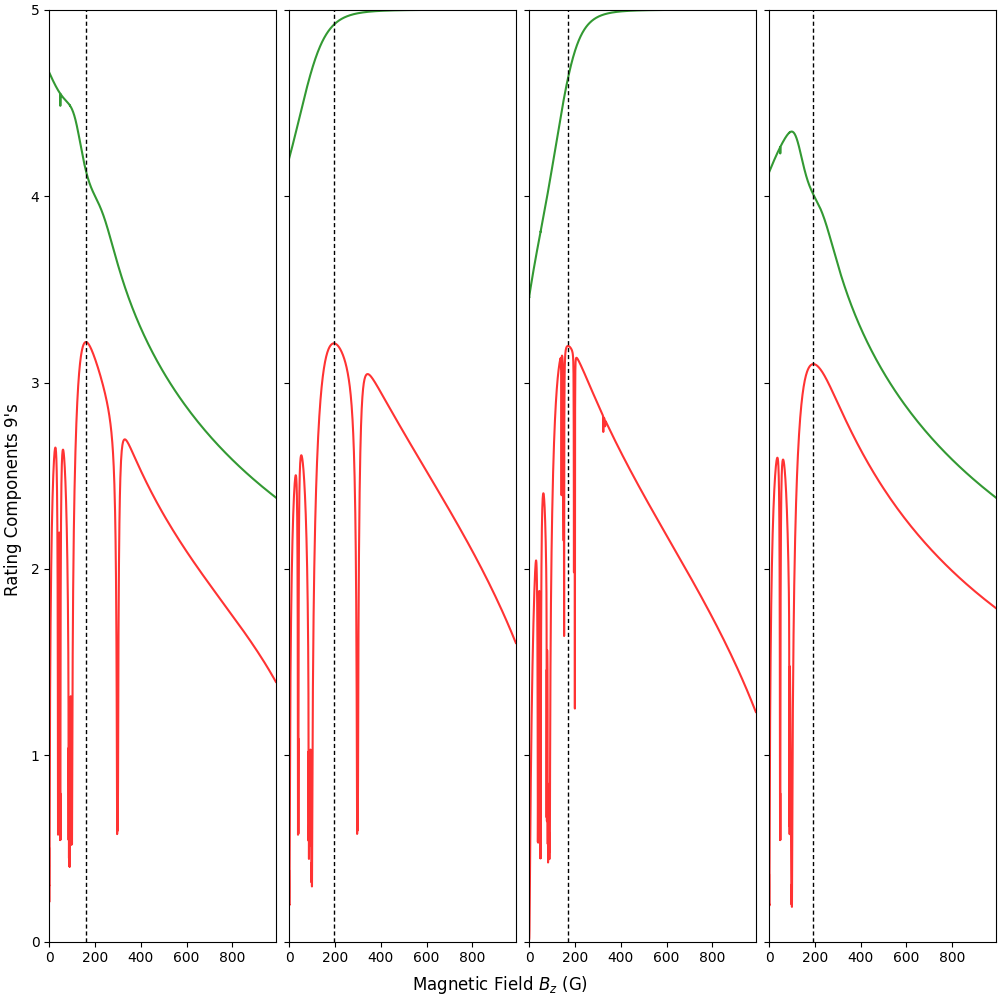

In [21]:
maximise_fid_dev(possibilities_d[:,:],required_crossing=[0,2],latex_table=True,save_name=f"{MOLECULE_STRING}-qubit",
                rate_deviation_fid=False, rate_unpol_distance_fid=True, rate_pol_distance_fid=False, rate_unpol_fid=True, rate_pol_fid=False)

# Robust Storage Bit in N=0 Optimisation

In [22]:
print("Robust Storage Qubit N=0 Optimisation")

possibilities = []
for N1 in [1]: #range(0,N_MAX+1): #[1]:#
    for N2 in [0]: #[N1-1,N1+1]: #[0]:#
        if N2 < 0 or N2 > N_MAX:
            continue
        F1_D = 2*N1+I1_D+I2_D
        F2_D = 2*N2+I1_D+I2_D
        for MF1_D in range(-F1_D,F1_D+1,2):#[2,3,4,5]+([6] if N1>0 else []):#range(-F1,F1+1,1):
            for p1 in [-1,0,1]:
                for p2 in [-1,0,1]:
                    if MF1_D+2*p1 > F2_D or MF1_D+2*p1 < -F2_D or MF1_D+2*p2 > F2_D or MF1_D+2*p2 < -F2_D:
                        continue
                    MF2a_D = MF1_D+2*p1
                    MF2b_D = MF1_D+2*p2
                    if MF2a_D < MF2b_D:
                        continue
                    for i in range(label_degeneracy(N1,MF1_D)):
                        for j in range(label_degeneracy(N2,MF2a_D)):
                            for k in range(label_degeneracy(N2,MF2b_D)):
                                if MF2a_D == MF2b_D and j <= k:
                                    continue
                                possibilities.append([(N2,MF2a_D,j),(N1,MF1_D,i),(N2,MF2b_D,k)])
possibilities_d = np.array(possibilities)

Robust Storage Qubit N=0 Optimisation


4432 combinations to consider


100%|█████████████████████████████████████| 4432/4432 [00:00<00:00, 7217.90it/s]


'<table>\n<thead>\n<tr><th>States                   </th><th style="text-align: right;">  B(G)</th><th>MagDipFid  </th><th>UnPolFid   </th><th>PolFid     </th><th>UnPolDistFid  </th><th>PolDistFid  </th><th>UnPolOverall  </th><th>PolOverall  </th><th>Rating     </th><th>Path  </th></tr>\n</thead>\n<tbody>\n<tr><td>(0,4,1),(1,4,5),(0,4,0)  </td><td style="text-align: right;">  45.5</td><td>0.9998(3.8)</td><td>0.9898(2.0)</td><td>0.9992(3.1)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.9897(2.0)   </td><td>0.9991(3.0) </td><td>0.9897(2.0)</td><td>---   </td></tr>\n<tr><td>(0,2,3),(1,3,8),(0,2,2)  </td><td style="text-align: right;"> 121  </td><td>0.9992(3.1)</td><td>0.9849(1.8)</td><td>0.9989(2.9)</td><td>0.9986(2.9)   </td><td>0.9999(4.0) </td><td>0.9827(1.8)   </td><td>0.9979(2.7) </td><td>0.9827(1.8)</td><td>---   </td></tr>\n<tr><td>(0,2,3),(1,1,4),(0,2,2)  </td><td style="text-align: right;"> 122  </td><td>0.9992(3.1)</td><td>0.9835(1.8)</td><td>0.9991(3.1)</td><td>0.9986(2.9)   </td><td>0.9999(3.9) </td><td>0.9813(1.7)   </td><td>0.9982(2.7) </td><td>0.9813(1.7)</td><td>---   </td></tr>\n<tr><td>(0,4,1),(1,4,1),(0,4,0)  </td><td style="text-align: right;">  45.6</td><td>0.9975(2.6)</td><td>0.9830(1.8)</td><td>0.9984(2.8)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.9805(1.7)   </td><td>0.9959(2.4) </td><td>0.9805(1.7)</td><td>---   </td></tr>\n<tr><td>(0,2,3),(1,2,8),(0,2,2)  </td><td style="text-align: right;"> 122  </td><td>0.9960(2.4)</td><td>0.9854(1.8)</td><td>0.9971(2.5)</td><td>0.9986(2.9)   </td><td>0.9999(3.9) </td><td>0.9801(1.7)   </td><td>0.9930(2.2) </td><td>0.9801(1.7)</td><td>---   </td></tr>\n<tr><td>(0,2,3),(1,1,8),(0,1,2)  </td><td style="text-align: right;"> 177  </td><td>0.9997(3.5)</td><td>0.9782(1.7)</td><td>0.9986(2.9)</td><td>0.9990(3.0)   </td><td>0.9999(3.9) </td><td>0.9769(1.6)   </td><td>0.9982(2.7) </td><td>0.9769(1.6)</td><td>---   </td></tr>\n<tr><td>(0,1,3),(1,0,3),(0,1,2)  </td><td style="text-align: right;">  84.6</td><td>0.9995(3.3)</td><td>0.9954(2.3)</td><td>0.9994(3.2)</td><td>0.9818(1.7)   </td><td>0.9995(3.3) </td><td>0.9767(1.6)   </td><td>0.9984(2.8) </td><td>0.9767(1.6)</td><td>---   </td></tr>\n<tr><td>(0,0,3),(1,-1,8),(0,-1,2)</td><td style="text-align: right;"> 157  </td><td>0.9995(3.3)</td><td>0.9891(2.0)</td><td>0.9984(2.8)</td><td>0.9842(1.8)   </td><td>0.9988(2.9) </td><td>0.9730(1.6)   </td><td>0.9968(2.5) </td><td>0.9730(1.6)</td><td>---   </td></tr>\n<tr><td>(0,2,3),(1,2,3),(0,2,2)  </td><td style="text-align: right;"> 122  </td><td>0.9937(2.2)</td><td>0.9804(1.7)</td><td>0.9984(2.8)</td><td>0.9986(2.9)   </td><td>0.9999(3.9) </td><td>0.9730(1.6)   </td><td>0.9920(2.1) </td><td>0.9730(1.6)</td><td>---   </td></tr>\n<tr><td>(0,1,3),(1,2,10),(0,1,2) </td><td style="text-align: right;">  84.6</td><td>0.9980(2.7)</td><td>0.9902(2.0)</td><td>0.9991(3.1)</td><td>0.9831(1.8)   </td><td>0.9996(3.4) </td><td>0.9715(1.5)   </td><td>0.9967(2.5) </td><td>0.9715(1.5)</td><td>---   </td></tr>\n<tr><td>(0,3,2),(1,2,7),(0,2,1)  </td><td style="text-align: right;"> 177  </td><td>0.9935(2.2)</td><td>0.9785(1.7)</td><td>0.9947(2.3)</td><td>0.9977(2.6)   </td><td>0.9999(4.0) </td><td>0.9698(1.5)   </td><td>0.9881(1.9) </td><td>0.9698(1.5)</td><td>---   </td></tr>\n<tr><td>(0,0,3),(1,1,11),(0,0,2) </td><td style="text-align: right;">  27.1</td><td>0.9948(2.3)</td><td>0.9878(1.9)</td><td>0.9993(3.1)</td><td>0.9846(1.8)   </td><td>0.9994(3.2) </td><td>0.9674(1.5)   </td><td>0.9935(2.2) </td><td>0.9674(1.5)</td><td>---   </td></tr>\n</tbody>\n</table>'

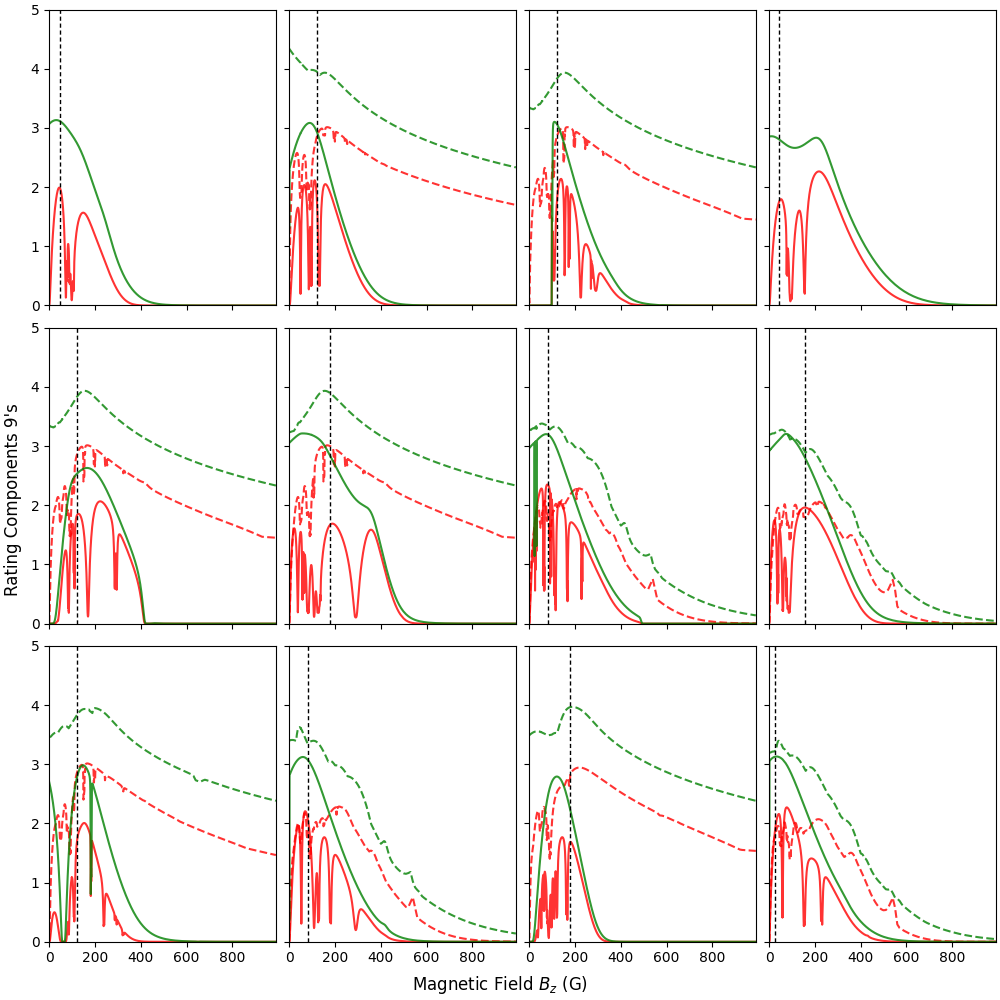

In [23]:
maximise_fid_dev(possibilities_d[:,:],table_len=12,x_plots=4,y_plots=3,required_crossing=[0,2],latex_table=True,save_name=f"{MOLECULE_STRING}-qubit-zero",allow_travel=True)

# Varying time for a set of states

1 combinations to consider


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1051.47it/s]


'<table>\n<thead>\n<tr><th>States                 </th><th style="text-align: right;">  B(G)</th><th>MagDipFid   </th><th>UnPolFid    </th><th>PolFid      </th><th>UnPolDistFid  </th><th>PolDistFid  </th><th>UnPolOverall  </th><th>PolOverall  </th><th>Rating      </th><th>Path  </th></tr>\n</thead>\n<tbody>\n<tr><td>(0,4,1),(1,3,1),(0,3,0)</td><td style="text-align: right;">  36.7</td><td>0.9888(2.0) </td><td>0.9797(1.7) </td><td>0.9987(2.9) </td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.9687(1.5)   </td><td>0.9875(1.9) </td><td>0.9687(1.5) </td><td>---   </td></tr>\n<tr><td>(0,4,1),(1,3,1),(0,3,0)</td><td style="text-align: right;">   0.1</td><td>0.0000(-0.0)</td><td>0.0000(-0.0)</td><td>0.0000(-0.0)</td><td>0.0000(-0.0)  </td><td>0.0000(-0.0)</td><td>0.0000(-0.0)  </td><td>0.0000(-0.0)</td><td>0.0000(-0.0)</td><td>---   </td></tr>\n</tbody>\n</table>'

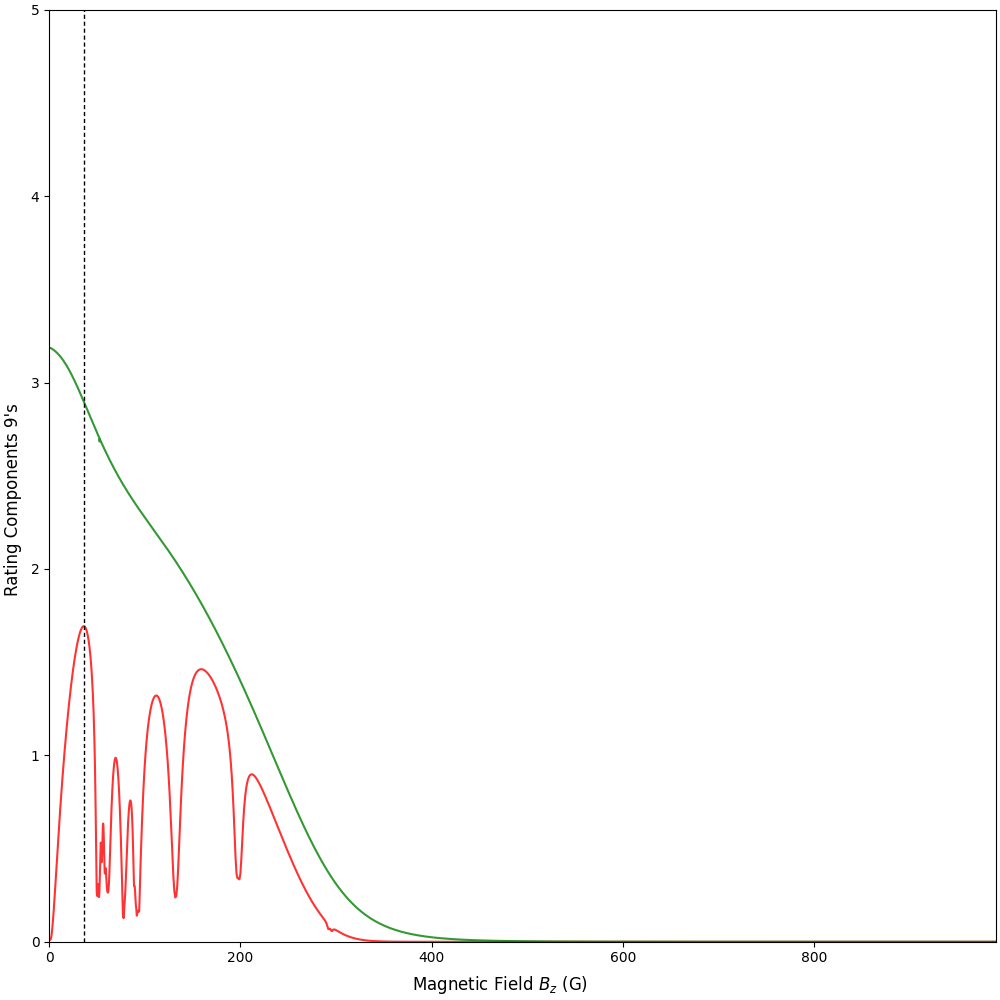

In [24]:
possibilities = [[(0,8,1),(1,6,1),(0,6,0)]]
maximise_fid_dev(possibilities,latex_table=True,table_len=2,save_name=f"{MOLECULE_STRING}-2-state",x_plots=1,y_plots=1)

# 2-state

In [25]:
print("2-state optimisation")

states=[]
for N1 in range(0,N_MAX): #[1]:#
    N2=N1+1
    F1_D = 2*N1+I1_D+I2_D
    for MF1_D in range(-F1_D,F1_D+1,2):
        for MF2_D in [MF1_D-2,MF1_D,MF1_D+2]:
            for i in range(label_degeneracy(N1,MF1_D)):
                for j in range(label_degeneracy(N2,MF2_D)):
                    states.append([(N1,MF1_D,i),(N2,MF2_D,j)])           
states=np.array(states)

2-state optimisation


In [26]:
label_degeneracy(5,0)

32

In [27]:
per_mn = 64
n_max = 6
bytes_per_float = 4
values_per_pair = 3
b_steps = 1000
degeneracy = 32
connectivity = 6*degeneracy



total_bytes = per_mn*(n_max+1)**2 * ((bytes_per_float*values_per_pair) * b_steps) * connectivity
print(f"{total_bytes*1e-6}MB")

7225.344MB


5300 combinations to consider


100%|████████████████████████████████████| 5300/5300 [00:00<00:00, 16396.94it/s]


'<table>\n<thead>\n<tr><th>States         </th><th style="text-align: right;">  B(G)</th><th>MagDipFid  </th><th>UnPolFid    </th><th>PolFid     </th><th>UnPolDistFid  </th><th>PolDistFid  </th><th>UnPolOverall  </th><th>PolOverall  </th><th>Rating     </th><th>Path  </th></tr>\n</thead>\n<tbody>\n<tr><td>(0,4,1),(1,4,3)</td><td style="text-align: right;"> 368  </td><td>1.0000(6.9)</td><td>0.9999(3.9) </td><td>1.0000(5.4)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.9999(3.9)   </td><td>1.0000(5.4) </td><td>1.0000(6.9)</td><td>---   </td></tr>\n<tr><td>(0,4,1),(1,4,5)</td><td style="text-align: right;">  53.9</td><td>1.0000(6.3)</td><td>0.9968(2.5) </td><td>0.9997(3.5)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.9968(2.5)   </td><td>0.9997(3.5) </td><td>1.0000(6.3)</td><td>---   </td></tr>\n<tr><td>(0,4,1),(1,4,0)</td><td style="text-align: right;">  84.8</td><td>1.0000(6.3)</td><td>0.4745(0.3) </td><td>0.9804(1.7)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.4745(0.3)   </td><td>0.9804(1.7) </td><td>1.0000(6.3)</td><td>---   </td></tr>\n<tr><td>(0,4,1),(1,4,1)</td><td style="text-align: right;">  71.1</td><td>1.0000(5.6)</td><td>0.9926(2.1) </td><td>0.9998(3.7)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.9926(2.1)   </td><td>0.9998(3.6) </td><td>1.0000(5.6)</td><td>---   </td></tr>\n<tr><td>(0,4,1),(1,5,0)</td><td style="text-align: right;">   3.7</td><td>1.0000(5.5)</td><td>0.2582(0.1) </td><td>0.9973(2.6)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.2582(0.1)   </td><td>0.9973(2.6) </td><td>1.0000(5.5)</td><td>---   </td></tr>\n<tr><td>(0,4,1),(1,3,0)</td><td style="text-align: right;"> 159  </td><td>1.0000(5.4)</td><td>0.0000(0.0) </td><td>0.0175(0.0)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.0000(0.0)   </td><td>0.0175(0.0) </td><td>1.0000(5.4)</td><td>---   </td></tr>\n<tr><td>(0,4,1),(1,4,2)</td><td style="text-align: right;"> 152  </td><td>1.0000(5.1)</td><td>0.0000(-0.0)</td><td>0.0000(0.0)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.0000(-0.0)  </td><td>0.0000(0.0) </td><td>1.0000(5.1)</td><td>---   </td></tr>\n<tr><td>(0,4,1),(1,3,1)</td><td style="text-align: right;"> 152  </td><td>1.0000(4.6)</td><td>0.9786(1.7) </td><td>0.9878(1.9)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.9785(1.7)   </td><td>0.9878(1.9) </td><td>1.0000(4.6)</td><td>---   </td></tr>\n<tr><td>(0,5,0),(1,6,0)</td><td style="text-align: right;"> 990  </td><td>1.0000(4.4)</td><td>0.9753(1.6) </td><td>1.0000(9.0)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.9752(1.6)   </td><td>1.0000(4.4) </td><td>1.0000(4.4)</td><td>---   </td></tr>\n<tr><td>(0,5,0),(1,5,0)</td><td style="text-align: right;"> 990  </td><td>0.9999(4.2)</td><td>0.9998(3.7) </td><td>1.0000(8.3)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.9997(3.6)   </td><td>0.9999(4.2) </td><td>0.9999(4.2)</td><td>---   </td></tr>\n<tr><td>(0,4,1),(1,3,2)</td><td style="text-align: right;"> 990  </td><td>0.9999(4.0)</td><td>0.9704(1.5) </td><td>1.0000(8.8)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.9703(1.5)   </td><td>0.9999(4.0) </td><td>0.9999(4.0)</td><td>---   </td></tr>\n<tr><td>(0,4,1),(1,5,2)</td><td style="text-align: right;"> 990  </td><td>0.9999(4.0)</td><td>0.9702(1.5) </td><td>1.0000(8.4)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.9701(1.5)   </td><td>0.9999(4.0) </td><td>0.9999(4.0)</td><td>---   </td></tr>\n<tr><td>(1,4,3),(2,3,4)</td><td style="text-align: right;"> 403  </td><td>1.0000(6.9)</td><td>0.9778(1.7) </td><td>1.0000(5.8)</td><td>0.9999(3.9)   </td><td>1.0000(6.3) </td><td>0.9777(1.7)   </td><td>1.0000(5.7) </td><td>0.9999(3.9)</td><td>---   </td></tr>\n<tr><td>(1,4,3),(2,5,3)</td><td style="text-align: right;"> 990  </td><td>1.0000(5.4)</td><td>0.9866(1.9) </td><td>1.0000(8.1)</td><td>0.9999(3.9)   </td><td>1.0000(8.4) </td><td>0.9865(1.9)   </td><td>1.0000(5.4) </td><td>0.9999(3.9)</td><td>---   </td></tr>\n<tr><td>(0,5,0),(1,4,0)</td><td style="text-ali

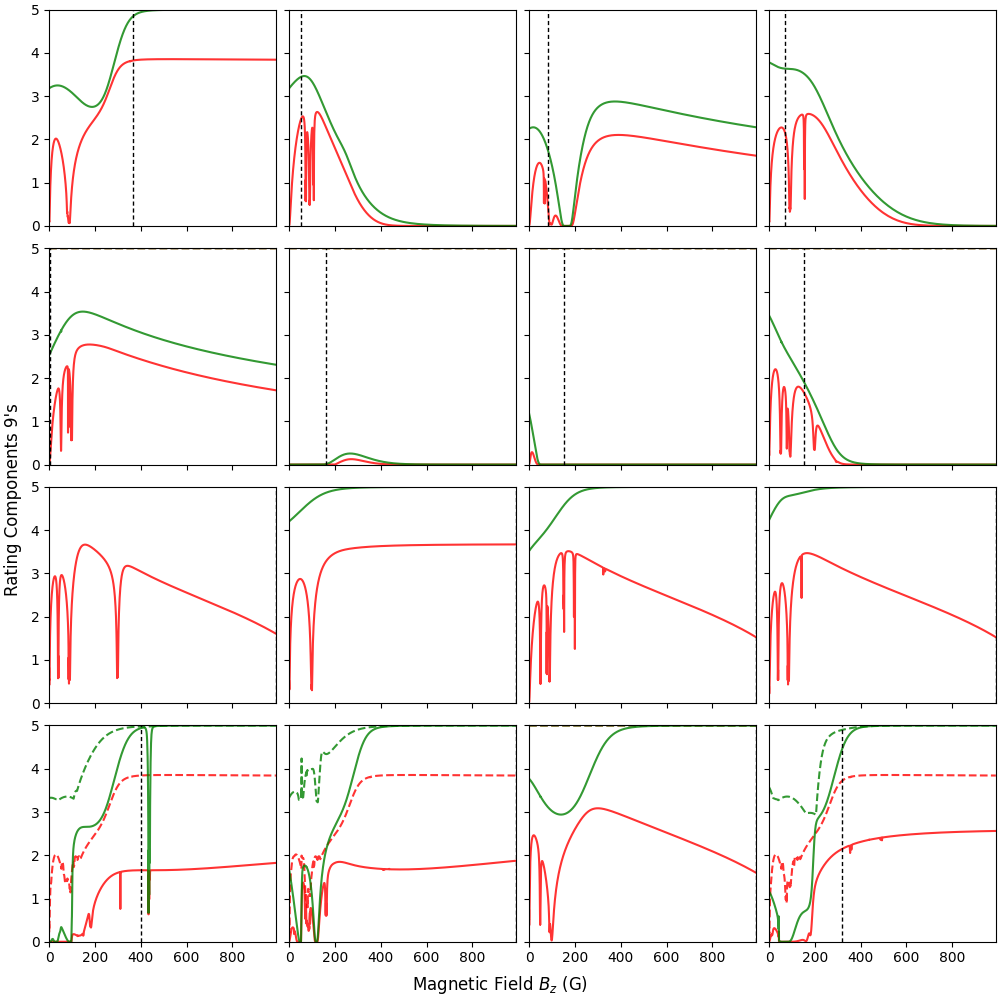

In [28]:
maximise_fid_dev(states,latex_table=True,save_name=f"{MOLECULE_STRING}-2-state", table_len=20,
                rate_deviation_fid=True, rate_unpol_distance_fid=True, rate_pol_distance_fid=False, rate_unpol_fid=False, rate_pol_fid=False,
                x_plots=4, y_plots=4)


# 3-state

In [29]:
print("3-state optimisation")

states=[]
N1=0
N2=1
N3=2
F1_D = 2*N1+I1_D+I2_D
for MF1_D in range(-F1_D,F1_D+1,2):
    for MF2_D in [MF1_D-2,MF1_D,MF1_D+2]:
        for MF3_D in [MF2_D-2,MF2_D,MF2_D+2]:
            for i in range(label_degeneracy(N1,MF1_D)):
                for j in range(label_degeneracy(N2,MF2_D)):
                    for k in range(label_degeneracy(N3,MF3_D)):
                        states.append([(N1,MF1_D,i),(N2,MF2_D,j),(N3,MF3_D,k)])           
states=np.array(states)

3-state optimisation


45744 combinations to consider


100%|███████████████████████████████████| 45744/45744 [00:05<00:00, 7883.97it/s]


'<table>\n<thead>\n<tr><th>States                 </th><th style="text-align: right;">  B(G)</th><th>MagDipFid  </th><th>UnPolFid   </th><th>PolFid     </th><th>UnPolDistFid  </th><th>PolDistFid  </th><th>UnPolOverall  </th><th>PolOverall  </th><th>Rating     </th><th>Path  </th></tr>\n</thead>\n<tbody>\n<tr><td>(0,5,0),(1,6,0),(2,7,0)</td><td style="text-align: right;">   167</td><td>0.9999(4.1)</td><td>0.9997(3.6)</td><td>1.0000(9.0)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.9996(3.4)   </td><td>0.9999(4.1) </td><td>0.9996(3.4)</td><td>---   </td></tr>\n<tr><td>(0,4,1),(1,3,2),(2,2,2)</td><td style="text-align: right;">   303</td><td>0.9994(3.2)</td><td>0.9993(3.2)</td><td>1.0000(5.7)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.9987(2.9)   </td><td>0.9994(3.2) </td><td>0.9987(2.9)</td><td>---   </td></tr>\n<tr><td>(0,4,1),(1,5,2),(2,6,2)</td><td style="text-align: right;">   353</td><td>0.9991(3.1)</td><td>0.9989(3.0)</td><td>1.0000(6.5)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.9981(2.7)   </td><td>0.9991(3.1) </td><td>0.9981(2.7)</td><td>---   </td></tr>\n<tr><td>(0,5,0),(1,4,0),(2,3,0)</td><td style="text-align: right;">   410</td><td>0.9990(3.0)</td><td>0.9987(2.9)</td><td>1.0000(5.6)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.9977(2.6)   </td><td>0.9990(3.0) </td><td>0.9977(2.6)</td><td>---   </td></tr>\n<tr><td>(0,4,1),(1,3,2),(2,2,3)</td><td style="text-align: right;">   170</td><td>0.9981(2.7)</td><td>0.9991(3.1)</td><td>0.9997(3.6)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.9972(2.6)   </td><td>0.9978(2.7) </td><td>0.9972(2.6)</td><td>---   </td></tr>\n<tr><td>(0,4,1),(1,5,2),(2,5,3)</td><td style="text-align: right;">   366</td><td>0.9994(3.2)</td><td>0.9978(2.6)</td><td>1.0000(6.1)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.9972(2.6)   </td><td>0.9994(3.2) </td><td>0.9972(2.6)</td><td>---   </td></tr>\n<tr><td>(0,3,2),(1,4,5),(2,5,5)</td><td style="text-align: right;">   295</td><td>0.9988(2.9)</td><td>0.9993(3.2)</td><td>1.0000(6.0)</td><td>0.9990(3.0)   </td><td>0.9998(3.7) </td><td>0.9971(2.5)   </td><td>0.9986(2.9) </td><td>0.9971(2.5)</td><td>---   </td></tr>\n<tr><td>(0,4,1),(1,4,3),(2,4,3)</td><td style="text-align: right;">   990</td><td>0.9999(4.1)</td><td>0.9971(2.5)</td><td>1.0000(8.2)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.9971(2.5)   </td><td>0.9999(4.1) </td><td>0.9971(2.5)</td><td>---   </td></tr>\n</tbody>\n</table>'

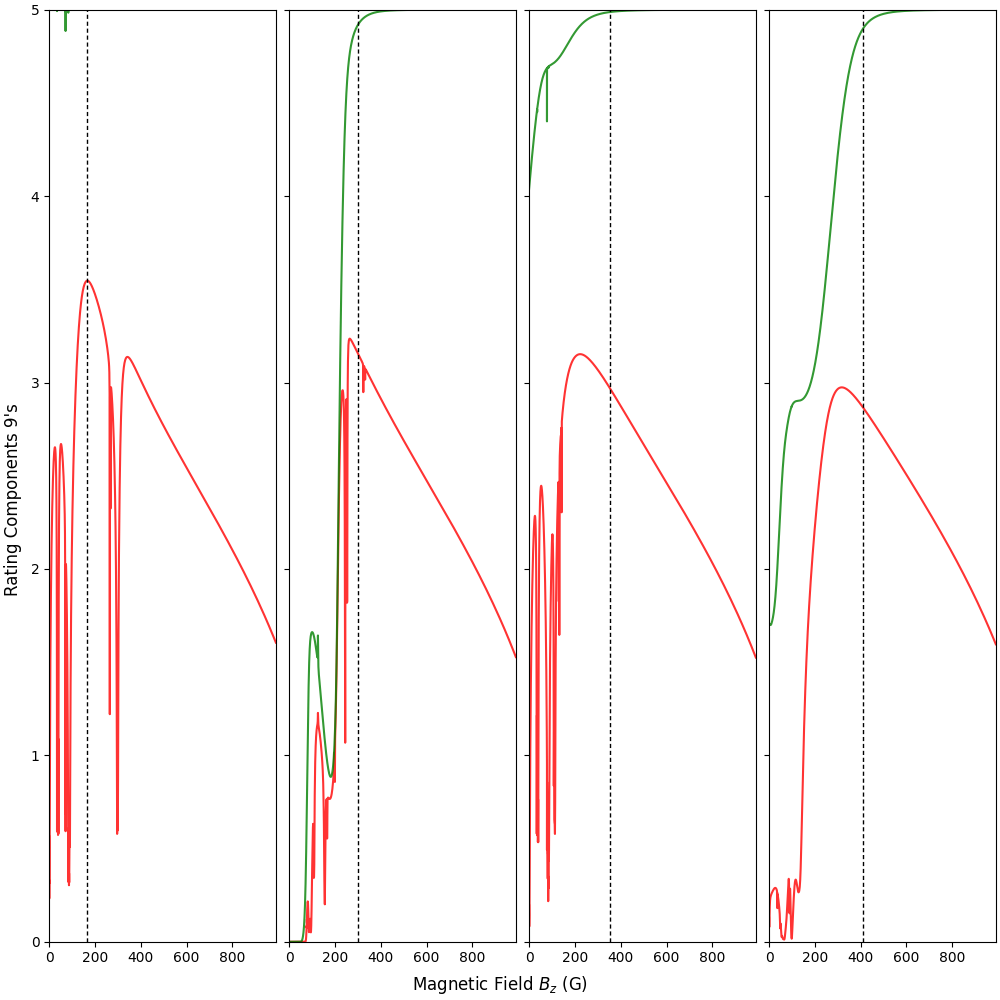

In [30]:
maximise_fid_dev(states,latex_table=True, save_name=f"{MOLECULE_STRING}-3-state")

# 4-state loop Optimisation

In [31]:
print("4-state loop optimisation")

# Find all possible combinations
polarisations = []
for p1 in [-1,0,1]:
    for p2 in [-1,0,1]:
        for p3 in [-1,0,1]:
            for p4 in [-1,0,1]:
                if p1+p2+p3+p4 == 0:
                    polarisations.append((p1,p2,p3,p4))

state_mfs = []            
F1_D = I1_D+I2_D
for base_mf_d in range(-F1_D,F1_D+1,2):
    for p1,p2,p3,_ in polarisations:
        state_mfs.append((base_mf_d,base_mf_d+2*p1,base_mf_d+2*p1+2*p2,base_mf_d+2*p1+2*p2+2*p3))

states = []
for state_mf in state_mfs:
    for i in range(label_degeneracy(0,state_mf[0])):
        for j in range(label_degeneracy(1,state_mf[1])):
            for k in range(label_degeneracy(2,state_mf[2])):
                for l in range(label_degeneracy(1,state_mf[3])):
                    if (state_mf[1]<state_mf[3]) or (state_mf[1]==state_mf[3] and j<=l):
                        continue
                    states.append([(0,state_mf[0],i),(1,state_mf[1],j),(2,state_mf[2],k),(1,state_mf[3],l)])
                    
states=np.array(states)

4-state loop optimisation


504014 combinations to consider


100%|█████████████████████████████████| 504014/504014 [01:26<00:00, 5840.34it/s]


'<table>\n<thead>\n<tr><th>States                               </th><th style="text-align: right;">  B(G)</th><th>MagDipFid  </th><th>UnPolFid   </th><th>PolFid     </th><th>UnPolDistFid  </th><th>PolDistFid  </th><th>UnPolOverall  </th><th>PolOverall  </th><th>Rating     </th><th>Path  </th></tr>\n</thead>\n<tbody>\n<tr><td>(0,-5,0),(1,-4,5),(2,-4,9),(1,-5,0)  </td><td style="text-align: right;">  52.8</td><td>0.9910(2.0)</td><td>0.9980(2.7)</td><td>0.9999(3.9)</td><td>0.9497(1.3)   </td><td>0.9977(2.6) </td><td>0.9393(1.2)   </td><td>0.9886(1.9) </td><td>0.9980(2.7)</td><td>---   </td></tr>\n<tr><td>(0,-4,1),(1,-3,8),(2,-3,12),(1,-4,1) </td><td style="text-align: right;">  92.6</td><td>0.9908(2.0)</td><td>0.9974(2.6)</td><td>0.9998(3.6)</td><td>0.9446(1.3)   </td><td>0.9977(2.6) </td><td>0.9334(1.2)   </td><td>0.9883(1.9) </td><td>0.9974(2.6)</td><td>---   </td></tr>\n<tr><td>(0,-5,0),(1,-5,0),(2,-6,0),(1,-6,0)  </td><td style="text-align: right;">  71.2</td><td>0.9897(2.0)</td><td>0.9972(2.6)</td><td>0.9997(3.6)</td><td>0.9532(1.3)   </td><td>0.9970(2.5) </td><td>0.9407(1.2)   </td><td>0.9866(1.9) </td><td>0.9972(2.6)</td><td>---   </td></tr>\n<tr><td>(0,-4,0),(1,-4,5),(2,-4,9),(1,-5,0)  </td><td style="text-align: right;">  45.5</td><td>0.9936(2.2)</td><td>0.9971(2.5)</td><td>0.9998(3.7)</td><td>0.9517(1.3)   </td><td>0.9979(2.7) </td><td>0.9429(1.2)   </td><td>0.9914(2.1) </td><td>0.9971(2.5)</td><td>---   </td></tr>\n<tr><td>(0,3,2),(1,3,8),(2,2,8),(1,2,3)      </td><td style="text-align: right;"> 221  </td><td>0.9898(2.0)</td><td>0.9969(2.5)</td><td>0.9994(3.2)</td><td>0.9989(2.9)   </td><td>0.9999(4.0) </td><td>0.9856(1.8)   </td><td>0.9890(2.0) </td><td>0.9969(2.5)</td><td>---   </td></tr>\n<tr><td>(0,-3,1),(1,-3,8),(2,-3,12),(1,-4,1) </td><td style="text-align: right;"> 111  </td><td>0.9916(2.1)</td><td>0.9969(2.5)</td><td>0.9997(3.5)</td><td>0.9604(1.4)   </td><td>0.9971(2.5) </td><td>0.9494(1.3)   </td><td>0.9885(1.9) </td><td>0.9969(2.5)</td><td>---   </td></tr>\n<tr><td>(0,3,2),(1,4,5),(2,4,9),(1,3,8)      </td><td style="text-align: right;"> 194  </td><td>0.9860(1.9)</td><td>0.9968(2.5)</td><td>0.9996(3.4)</td><td>0.9996(3.4)   </td><td>0.9999(4.1) </td><td>0.9824(1.8)   </td><td>0.9855(1.8) </td><td>0.9968(2.5)</td><td>---   </td></tr>\n<tr><td>(0,2,3),(1,3,8),(2,2,8),(1,2,3)      </td><td style="text-align: right;"> 220  </td><td>0.9887(1.9)</td><td>0.9967(2.5)</td><td>0.9994(3.2)</td><td>0.9987(2.9)   </td><td>0.9999(4.0) </td><td>0.9842(1.8)   </td><td>0.9880(1.9) </td><td>0.9967(2.5)</td><td>---   </td></tr>\n<tr><td>(0,-5,0),(1,-4,5),(2,-5,2),(1,-5,0)  </td><td style="text-align: right;">  94.9</td><td>0.9886(1.9)</td><td>0.9967(2.5)</td><td>0.9998(3.6)</td><td>0.9431(1.2)   </td><td>0.9965(2.5) </td><td>0.9292(1.2)   </td><td>0.9849(1.8) </td><td>0.9967(2.5)</td><td>---   </td></tr>\n<tr><td>(0,2,3),(1,3,8),(2,4,9),(1,3,2)      </td><td style="text-align: right;"> 203  </td><td>0.9780(1.7)</td><td>0.9966(2.5)</td><td>0.9988(2.9)</td><td>0.9996(3.4)   </td><td>1.0000(5.3) </td><td>0.9743(1.6)   </td><td>0.9769(1.6) </td><td>0.9966(2.5)</td><td>---   </td></tr>\n<tr><td>(0,-4,0),(1,-4,5),(2,-5,2),(1,-5,0)  </td><td style="text-align: right;"> 154  </td><td>0.9904(2.0)</td><td>0.9965(2.5)</td><td>0.9996(3.4)</td><td>0.9556(1.4)   </td><td>0.9949(2.3) </td><td>0.9431(1.2)   </td><td>0.9849(1.8) </td><td>0.9965(2.5)</td><td>---   </td></tr>\n<tr><td>(0,-3,2),(1,-2,10),(2,-2,15),(1,-3,2)</td><td style="text-align: right;">  66  </td><td>0.9923(2.1)</td><td>0.9962(2.4)</td><td>0.9997(3.5)</td><td>0.9773(1.6)   </td><td>0.9991(3.0) </td><td>0.9661(1.5)   </td><td>0.9911(2.0) </td><td>0.9962(2.4)</td><td>---   </td></tr>\n<tr><td>(0,4,1),(1,3,8),(2,4,9),(1,3,2)      </td><td style="text-align: right;"> 183  </td><td>0.9780(1.7)</td><td>0.9960(2.4)</td><td>0.9988(2.9)</td><td>1.0000(9.0)   </td><td>1.0000(9.0) </td><td>0.9741(1.6)   </td><td>0.9768(1.6) </td><td>0.9960(2.4)</td><td>---   </td></tr>\n<tr><td>(0,-5,

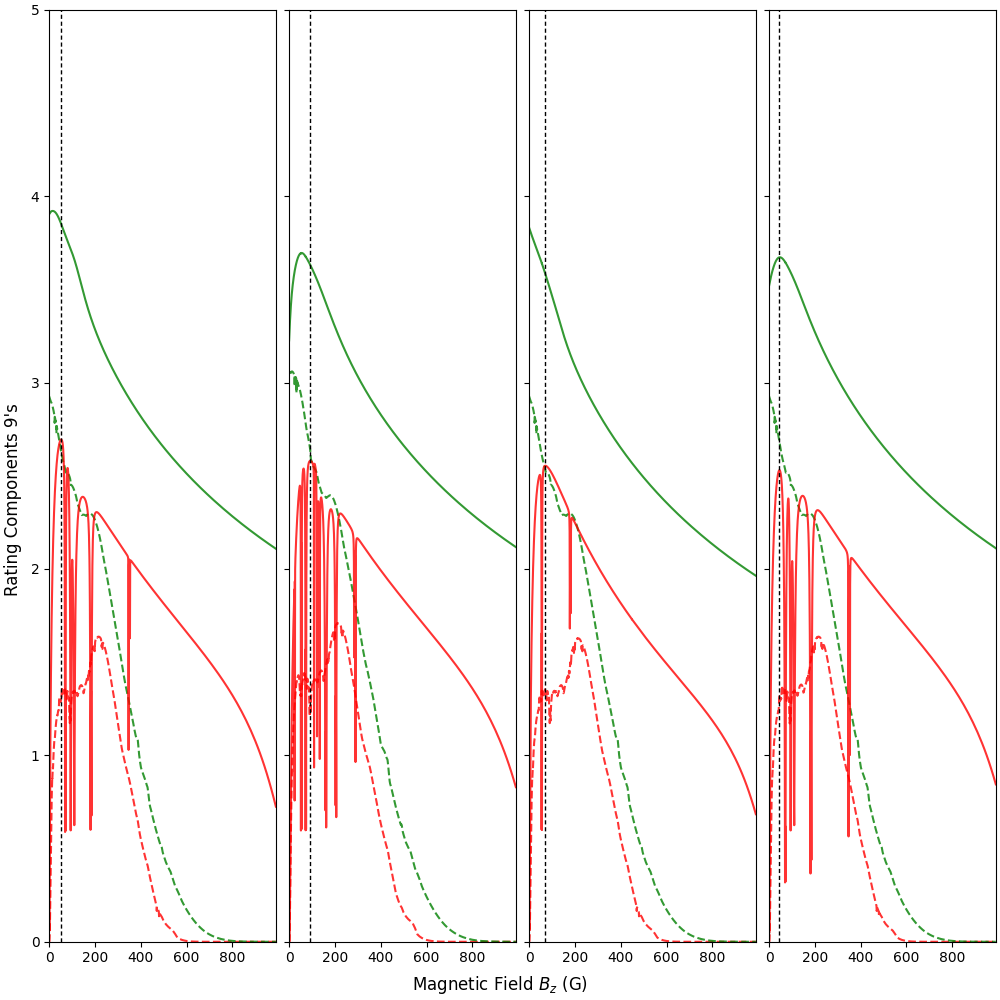

In [33]:
maximise_fid_dev(states,loop=True,latex_table=True,table_len=20,save_name=f"{MOLECULE_STRING}-4-state",
                rate_deviation_fid=False, rate_unpol_distance_fid=False, rate_pol_distance_fid=False, rate_unpol_fid=True, rate_pol_fid=False)